In [1]:
#!/usr/bin/env python3.4

import os
import re
import numpy as np
import uuid
from scipy import misc
import numpy as np
from PIL import Image
import sys


def read(file):
    if file.endswith('.float3'): return readFloat(file)
    elif file.endswith('.flo'): return readFlow(file)
    elif file.endswith('.ppm'): return readImage(file)
    elif file.endswith('.pgm'): return readImage(file)
    elif file.endswith('.png'): return readImage(file)
    elif file.endswith('.jpg'): return readImage(file)
    elif file.endswith('.pfm'): return readPFM(file)[0]
    else: raise Exception('don\'t know how to read %s' % file)

def write(file, data):
    if file.endswith('.float3'): return writeFloat(file, data)
    elif file.endswith('.flo'): return writeFlow(file, data)
    elif file.endswith('.ppm'): return writeImage(file, data)
    elif file.endswith('.pgm'): return writeImage(file, data)
    elif file.endswith('.png'): return writeImage(file, data)
    elif file.endswith('.jpg'): return writeImage(file, data)
    elif file.endswith('.pfm'): return writePFM(file, data)
    else: raise Exception('don\'t know how to write %s' % file)

def readPFM(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode("ascii") == 'PF':
        color = True
    elif header.decode("ascii") == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode("ascii"))
    if dim_match:
        width, height = list(map(int, dim_match.groups()))
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode("ascii").rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data, scale

def writePFM(file, image, scale=1):
    file = open(file, 'wb')

    color = None

    if image.dtype.name != 'float32':
        raise Exception('Image dtype must be float32.')

    image = np.flipud(image)

    if len(image.shape) == 3 and image.shape[2] == 3: # color image
        color = True
    elif len(image.shape) == 2 or len(image.shape) == 3 and image.shape[2] == 1: # greyscale
        color = False
    else:
        raise Exception('Image must have H x W x 3, H x W x 1 or H x W dimensions.')

    file.write('PF\n' if color else 'Pf\n'.encode())
    file.write('%d %d\n'.encode() % (image.shape[1], image.shape[0]))

    endian = image.dtype.byteorder

    if endian == '<' or endian == '=' and sys.byteorder == 'little':
        scale = -scale

    file.write('%f\n'.encode() % scale)

    image.tofile(file)

def readFlow(name):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        return readPFM(name)[0][:,:,0:2]

    f = open(name, 'rb')

    header = f.read(4)
    if header.decode("utf-8") != 'PIEH':
        raise Exception('Flow file header does not contain PIEH')

    width = np.fromfile(f, np.int32, 1).squeeze()
    height = np.fromfile(f, np.int32, 1).squeeze()

    flow = np.fromfile(f, np.float32, width * height * 2).reshape((height, width, 2))

    return flow.astype(np.float32)

def readImage(name):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        data = readPFM(name)[0]
        if len(data.shape)==3:
            return data[:,:,0:3]
        else:
            return data

    return misc.imread(name)

def writeImage(name, data):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        return writePFM(name, data, 1)

    return misc.imsave(name, data)

def writeFlow(name, flow):
    f = open(name, 'wb')
    f.write('PIEH'.encode('utf-8'))
    np.array([flow.shape[1], flow.shape[0]], dtype=np.int32).tofile(f)
    flow = flow.astype(np.float32)
    flow.tofile(f)

def readFloat(name):
    f = open(name, 'rb')

    if(f.readline().decode("utf-8"))  != 'float\n':
        raise Exception('float file %s did not contain <float> keyword' % name)

    dim = int(f.readline())

    dims = []
    count = 1
    for i in range(0, dim):
        d = int(f.readline())
        dims.append(d)
        count *= d

    dims = list(reversed(dims))

    data = np.fromfile(f, np.float32, count).reshape(dims)
    if dim > 2:
        data = np.transpose(data, (2, 1, 0))
        data = np.transpose(data, (1, 0, 2))

    return data

def writeFloat(name, data):
    f = open(name, 'wb')

    dim=len(data.shape)
    if dim>3:
        raise Exception('bad float file dimension: %d' % dim)

    f.write(('float\n').encode('ascii'))
    f.write(('%d\n' % dim).encode('ascii'))

    if dim == 1:
        f.write(('%d\n' % data.shape[0]).encode('ascii'))
    else:
        f.write(('%d\n' % data.shape[1]).encode('ascii'))
        f.write(('%d\n' % data.shape[0]).encode('ascii'))
        for i in range(2, dim):
            f.write(('%d\n' % data.shape[i]).encode('ascii'))

    data = data.astype(np.float32)
    if dim==2:
        data.tofile(f)

    else:
        np.transpose(data, (2, 0, 1)).tofile(f)

In [2]:


import flowiz as f
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:


files = glob.glob('./root/FlyingChairs/data/*.flo')
files



['./root/FlyingChairs/data/07270_flow.flo',
 './root/FlyingChairs/data/14202_flow.flo',
 './root/FlyingChairs/data/07834_flow.flo',
 './root/FlyingChairs/data/05507_flow.flo',
 './root/FlyingChairs/data/15133_flow.flo',
 './root/FlyingChairs/data/13580_flow.flo',
 './root/FlyingChairs/data/17229_flow.flo',
 './root/FlyingChairs/data/13911_flow.flo',
 './root/FlyingChairs/data/14878_flow.flo',
 './root/FlyingChairs/data/06118_flow.flo',
 './root/FlyingChairs/data/16853_flow.flo',
 './root/FlyingChairs/data/07355_flow.flo',
 './root/FlyingChairs/data/12894_flow.flo',
 './root/FlyingChairs/data/13671_flow.flo',
 './root/FlyingChairs/data/16728_flow.flo',
 './root/FlyingChairs/data/08364_flow.flo',
 './root/FlyingChairs/data/22683_flow.flo',
 './root/FlyingChairs/data/00996_flow.flo',
 './root/FlyingChairs/data/20501_flow.flo',
 './root/FlyingChairs/data/09911_flow.flo',
 './root/FlyingChairs/data/18533_flow.flo',
 './root/FlyingChairs/data/09620_flow.flo',
 './root/FlyingChairs/data/05165

(384, 512, 3)


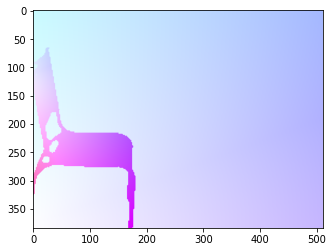

In [5]:
img = f.convert_from_file(files[30]) # load flo from file
print(img.shape)
plt.imshow(img)